# Langchain

## Acknowledgement

This notebook is based off: https://github.com/gkamradt/langchain-tutorials

In [50]:
!pip install --upgrade pip
!pip install langchain==0.0.198 --quiet

In [2]:
import langchain

print(langchain.__version__)
# assert int(langchain.__version__.split(".")[-1]) >= 194

0.0.198


## Model Deployment

Deploy from SageMaker JumpStart

- huggingface-text2text-flan-t5-xxl
- textembedding-gpt-j-6b-fp16

## Text

In [3]:
# You'll be working with simple strings (that'll soon grow in complexity!)
my_text = "What day comes after Friday?"

## Documents

In [4]:
from langchain.schema import Document

Document(page_content="This is my document. It is full of text that I've gathered from other places",
         metadata={
             'my_document_id' : 234234,
             'my_document_source' : "The LangChain Papers",
             'my_document_create_time' : 1680013019
         })

Document(lc_kwargs={'page_content': "This is my document. It is full of text that I've gathered from other places", 'metadata': {'my_document_id': 234234, 'my_document_source': 'The LangChain Papers', 'my_document_create_time': 1680013019}}, page_content="This is my document. It is full of text that I've gathered from other places", metadata={'my_document_id': 234234, 'my_document_source': 'The LangChain Papers', 'my_document_create_time': 1680013019})

## Chat Messages

In [5]:
from langchain.schema import HumanMessage, SystemMessage, AIMessage

[
    SystemMessage(content="You are a nice AI bot that helps a user figure out what to eat in one short sentence"),
    HumanMessage(content="I like tomatoes, what should I eat?")
]

[SystemMessage(lc_kwargs={'content': 'You are a nice AI bot that helps a user figure out what to eat in one short sentence'}, content='You are a nice AI bot that helps a user figure out what to eat in one short sentence', additional_kwargs={}),
 HumanMessage(lc_kwargs={'content': 'I like tomatoes, what should I eat?'}, content='I like tomatoes, what should I eat?', additional_kwargs={}, example=False)]

## Models

In [7]:
import json


_MODEL_CONFIG_ = {
    "huggingface-text2text-flan-t5-xxl" : {
        "aws_region": "us-east-1",
        "endpoint_name": "jumpstart-dft-hf-text2text-flan-t5-xxl"
    },
    
    "jumpstart-dft-hf-textembedding-gpt-j-6b-fp16": {
        "aws_region": "us-east-1",
        "endpoint_name": "jumpstart-dft-hf-textembedding-gpt-j-6b-fp16"
    }
}


from langchain.llms.sagemaker_endpoint import LLMContentHandler, SagemakerEndpoint

parameters = {
    "max_length": 200,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 1,
}


class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"text_inputs": prompt, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["generated_texts"][0]


content_handler = ContentHandler()

sm_llm = SagemakerEndpoint(
    endpoint_name=_MODEL_CONFIG_["huggingface-text2text-flan-t5-xxl"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["huggingface-text2text-flan-t5-xxl"]["aws_region"],
    model_kwargs=parameters,
    content_handler=content_handler,
)

In [8]:
sm_llm("What day comes after Friday?")

'saturday'

## Text Embedding Models

In [42]:
from typing import Dict, List
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.embeddings.sagemaker_endpoint import EmbeddingsContentHandler
import json


class ContentHandler(EmbeddingsContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, inputs: List[str], model_kwargs: Dict) -> bytes:
        input_str = json.dumps({"text_inputs": inputs, **model_kwargs})
        return input_str.encode('utf-8')

    def transform_output(self, output: bytes) -> List[List[float]]:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["embedding"]

content_handler = ContentHandler()


embeddings = SagemakerEndpointEmbeddings(
    endpoint_name=_MODEL_CONFIG_["jumpstart-dft-hf-textembedding-gpt-j-6b-fp16"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["jumpstart-dft-hf-textembedding-gpt-j-6b-fp16"]["aws_region"],
    content_handler=content_handler
)

In [22]:
text = "Hi! It's time for the beach"

text_embedding = embeddings.embed_query(text)
print (f"Your embedding is length {len(text_embedding)}")
print (f"Here's a sample: {text_embedding[:5]}...")

Your embedding is length 4096
Here's a sample: [0.01927047036588192, -0.014475125819444656, -0.015504071488976479, -0.010820756666362286, 0.007767584640532732]...


In [27]:
doc_embedding = embeddings.embed_documents([text])
print (f"Your embedding is length {len(doc_embedding[0])}")
print (f"Here's a sample: {doc_embedding[0][:5]}...")

Your embedding is length 4096
Here's a sample: [0.01927047036588192, -0.014475125819444656, -0.015504071488976479, -0.010820756666362286, 0.007767584640532732]...


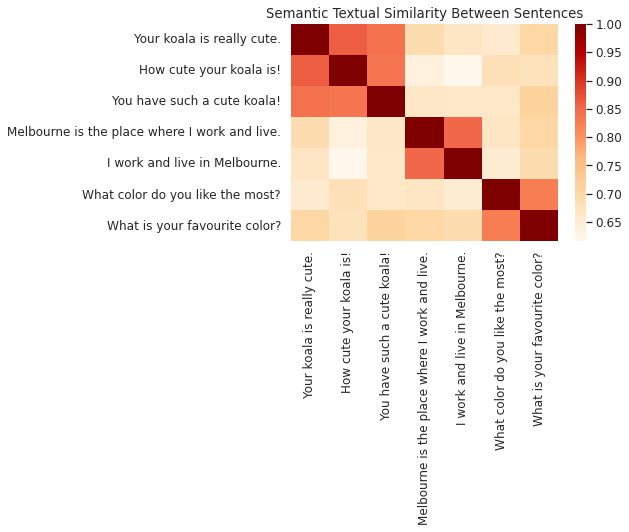

In [46]:
from sklearn.preprocessing import normalize
import seaborn as sns
import numpy as np

def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")
    
sentences = [
    # Pets
    "Your koala is really cute.",
    "How cute your koala is!",
    "You have such a cute koala!",
    # Location
    "Melbourne is the place where I work and live.",
    "I work and live in Melbourne.",
    # Color
    "What color do you like the most?",
    "What is your favourite color?",
]

doc_emb = embeddings.embed_documents(sentences)
plot_similarity_heatmap(
    sentences, normalize(
    np.array(doc_emb), axis=1), 
    90
)

## Prompt

In [48]:
prompt = """
Today is Monday, tomorrow is Wednesday.

What is wrong with that statement?
"""

sm_llm(prompt)

'Tuesday is a day after today, so it is Tuesday.'

## Prompt Template

In [52]:
from langchain import PromptTemplate

# Notice "location" below, that is a placeholder for another value later
template = """
I really want to travel to {location}. What should I do there?

Respond in one short sentence
"""

prompt = PromptTemplate(
    input_variables=["location"],
    template=template,
)

final_prompt = prompt.format(location='Melbourne')

print (f"Final Prompt: {final_prompt}")
print ("-----------")
print (f"LLM Output: {sm_llm(final_prompt)}")

Final Prompt: 
I really want to travel to Melbourne. What should I do there?

Respond in one short sentence

-----------
LLM Output: I should go to the Yarra Valley


## Example Selectors

In [59]:
!pip install faiss-cpu==1.7.4 --quiet

In [60]:
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.vectorstores import FAISS
from langchain.prompts import FewShotPromptTemplate, PromptTemplate


example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Example Input: {input}\nExample Output: {output}",
)

# Examples of locations that nouns are found
examples = [
    {"input": "pirate", "output": "ship"},
    {"input": "pilot", "output": "plane"},
    {"input": "driver", "output": "car"},
    {"input": "tree", "output": "ground"},
    {"input": "bird", "output": "nest"},
]

In [61]:
# SemanticSimilarityExampleSelector will select examples that are similar to your input by semantic meaning

example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples, 
    
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    embeddings, 
    
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS, 
    
    # This is the number of examples to produce.
    k=2
)

In [62]:
similar_prompt = FewShotPromptTemplate(
    # The object that will help select examples
    example_selector=example_selector,
    
    # Your prompt
    example_prompt=example_prompt,
    
    # Customizations that will be added to the top and bottom of your prompt
    prefix="Give the location an item is usually found in",
    suffix="Input: {noun}\nOutput:",
    
    # What inputs your prompt will receive
    input_variables=["noun"],
)

In [71]:
# Select a noun!
my_noun = "student"
my_noun = "flower"

print(similar_prompt.format(noun=my_noun))

Give the location an item is usually found in

Example Input: tree
Example Output: ground

Example Input: bird
Example Output: nest

Input: flower
Output:


In [72]:
sm_llm(similar_prompt.format(noun=my_noun))

'garden'

## Output Parsers

1. **Format Instructions** - A autogenerated prompt that tells the LLM how to format it's response based off your desired result
2. **Parser** - A method which will extract your model's text output into a desired structure (usually json)

#### No Formatting

In [264]:
prompt = PromptTemplate(
    template="List five {subject}:",
    input_variables=["subject"],
)

output = sm_llm(prompt.format(subject="ice cream flavors"))
output

'chocolate peanut butter snicker snicker snicker'

#### Proper Formatting

In [265]:
from langchain.output_parsers import CommaSeparatedListOutputParser, ResponseSchema
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.chains import LLMChain

In [266]:
output_parser = CommaSeparatedListOutputParser()
output_parser

CommaSeparatedListOutputParser(lc_kwargs={})

In [267]:
format_instructions = output_parser.get_format_instructions()
prompt = PromptTemplate(
    template="{format_instructions}\n\nList five {subject}:",
    input_variables=["subject"],
    partial_variables={"format_instructions": format_instructions}
)

In [268]:
format_instructions

'Your response should be a list of comma separated values, eg: `foo, bar, baz`'

In [269]:
print(prompt.format(subject="ice cream flavors"))

Your response should be a list of comma separated values, eg: `foo, bar, baz`

List five ice cream flavors:


In [270]:
_input = prompt.format(subject="ice cream flavors")
output = sm_llm(_input)
output

'vanilla, chocolate, strawberry, vanilla, rum raisin'

In [271]:
output_parser.parse(output)

['vanilla', 'chocolate', 'strawberry', 'vanilla', 'rum raisin']

In [258]:
# chain = LLMChain(prompt=prompt, llm=sm_llm)
# output = chain.run("ice cream flavors")
# print(output)
# output_parser.parse(output)

## Document Indexes

### Document Loaders

In [272]:
from langchain.document_loaders import HNLoader

In [273]:
loader = HNLoader("https://news.ycombinator.com/item?id=34422627")
data = loader.load()

print (f"Found {len(data)} comments")
print (f"Here's a sample:\n\n{''.join([x.page_content[:150] for x in data[:2]])}")

Found 76 comments
Here's a sample:

Ozzie_osman 4 months ago  
             | next [–] 

LangChain is awesome. For people not sure what it's doing, large language models (LLMs) are very Ozzie_osman 4 months ago  
             | parent | next [–] 

Also, another library to check out is GPT Index (https://github.com/jerryjliu/gpt_index)


### Text Splitter

In [274]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# This is a long document we can split up.
with open('data/PaulGrahamEssays/worked.txt') as f:
    pg_work = f.read()
    
print (f"You have {len([pg_work])} document")